# Polynomial Regression

Sometimes our data just aren't linear. We can extend the linear regression approach to fitting 'curvy' data in several ways. Today we'll introduce polynomial regression.

## What is a polynomial?

An equation composed of variables, variables raised to powers (e.g. squared, cubed, etc), and/or the product of variables and variables raised to powers.

Examples:
 - $y = x^2$
 - $y = 5 x^3 + 4.5^x - 3.6$
 - $y = x_1^2 + 3.7 x_1 x_2 +2.1 x_2^2$

And Taylor's theorem tells us that any smooth curve can be approximated within some range arbitrarily closely by some polynomial (if you took calculus, this is the foundation of the Taylor Series).

## But polynomials aren't linear!

True.

So we're going to create new features from which we can build a polynomial and our equation will be linear with regards to these new features. Whenever we create new features from existing features, we call that _**feature engineering**_.

Take for example the polynomial expression:

$$y = 5 + 3.1 x + 2.6 x^2 - 4 x^3$$

Now let's make a new set of features:

$$
\begin{align*}
z_1 &= x\\
z_2 &= x^2\\
z_3 &= x^3
\end{align*}
$$

Now substituting our new variables into our polynomial:

$$
y = 5 + 3.1 z_1 + 2.6 z_2 - 4 z_3
$$

This equation is linear with respect to our new features ($z_1, z_2, z_3$), so we can use linear regression to find the best fit coeffecients!

### Engineering Polynomial features

Scikit-learn provides a function [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that creates new polynomial features from our existing features. Let's examine this function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([1,2,3]).reshape(-1,1)

poly = PolynomialFeatures(degree=5, include_bias = False)
Z = poly.fit_transform(X)

Notice, each column corresponds to one of our new features.


### Creating some curvy synthetic data

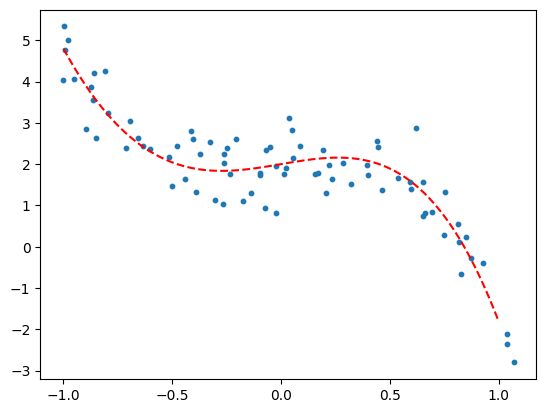

In [3]:
num_samples = 80

# Define polynomial coefficients for two different polynomials
poly_coeff = [-0.5, -4.2, 0, 0.9, 2]
my_poly = lambda z: np.polyval(poly_coeff, z)  # Polynomial function: -0.5*z^4 - 4.2*z^3 + 0.9*z + 2

# Generate random x data points
np.random.seed(98)
x = np.sort(np.linspace(-1, 1, num_samples) + np.random.normal(scale=0.1, size=num_samples))

# Plug the x data points into the polynomial function and add some noise
y = my_poly(x) + np.random.normal(loc=0, scale=0.5, size=num_samples)

# x_range is an array of data points in the x direction. y_range is the polynomial plotted over that range.
# These will be used to display the models.
x_range = np.linspace(-1, 1, 100).reshape(-1, 1)
y_range = my_poly(x_range)

# Plot the data points and polynomial curves
plt.scatter(x, y, s=10)
plt.plot(x_range, y_range, 'r--')

# Get y-axis limits for the plot
my_ylims = plt.gca().get_ylim()

plt.show()


### Fitting the models

Suppose we were presented the data above, not having made it ourselves. How would we know what degree of polynomial to use? We wouldn't.

So, we're going to fit polynomials of different degrees and inspect the results. We'll also fit Lasso, Ridge, and Elastic Net models to the data.

 - Linear Regression with polynomial features up to degree 1, 2, 4, 8, and 16
 - Lasso, Ridge, and Elastic Net with polynomial features up to degree 16 (we'll let regularization decide what stays and what goes)

In [4]:
## Linear Regressions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y, 
                                                    test_size = 0.5)

# Define the degrees of the polynomial features to be tested
degs = [1, 2, 4, 8, 16]

# Initialize a dictionary to store the models
models = {}

# Loop over each degree
for deg in degs:
    # Create polynomial features
    poly = PolynomialFeatures(degree=deg, include_bias=False)    
    Z_train = poly.fit_transform(x_train)
    Z_test = poly.transform(x_test)
    z_names = [f'xs^{d}' for d in range(1,deg+1)]

    
    # Standardize the features
    ss = StandardScaler()
    Z_train_scaled = ss.fit_transform(Z_train)
    Z_test_scaled = ss.transform(Z_test)

    # Train a linear regression model on the scaled polynomial features
    reg_poly = LinearRegression()
    reg_poly.fit(Z_train_scaled, y_train)

    # Transform the x_range using the polynomial features and the scaler
    # These aren't data, they're x- and y-values used to plot the model
    z_model = ss.transform(poly.transform(x_range))
    y_model = reg_poly.predict(z_model)

    # Calculate the R^2 score for training and testing sets
    R2_train = reg_poly.score(Z_train_scaled, y_train)
    R2_test = reg_poly.score(Z_test_scaled, y_test)
    
    # Store the model and its details in the dictionary
    key = f'Poly_{deg}'
    models[key] = dict(
        title = f'Poly {deg}',
        feature_names = z_names,
        scaler = ss,
        model = reg_poly,
        z_model = z_model,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )



In [5]:
## Lasso

from sklearn.linear_model import Lasso, Ridge, ElasticNet

alpha_test = 0.2

lasso_poly = Lasso(alpha = alpha_test)
lasso_poly.fit(Z_train_scaled, y_train)

y_model = lasso_poly.predict(z_model)

R2_train = lasso_poly.score(Z_train_scaled, y_train)
R2_test = lasso_poly.score(Z_test_scaled, y_test)

models['lasso'] = dict(
        title = f'Lasso',
        feature_names = z_names,
        scaler = ss,
        model = lasso_poly,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )


In [6]:
## Ridge

alpha_test = 1

ridge_poly = Ridge(alpha = alpha_test)
ridge_poly.fit(Z_train_scaled, y_train)

y_model = ridge_poly.predict(z_model)

R2_train = ridge_poly.score(Z_train_scaled, y_train)
R2_test = ridge_poly.score(Z_test_scaled, y_test)

models['ridge'] = dict(
        title = f'Ridge',
        feature_names = z_names,
        model = ridge_poly,
        scaler = ss,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )


In [7]:
## Elastic Net

elastic_poly = ElasticNet(alpha = alpha_test, l1_ratio = 0.7)
elastic_poly.fit(Z_train_scaled, y_train)

y_model = elastic_poly.predict(z_model)

R2_train = elastic_poly.score(Z_train_scaled, y_train)
R2_test = elastic_poly.score(Z_test_scaled, y_test)

models['elastic'] = dict(
        title = f'Elastic Net',
        feature_names = z_names,
        scaler = ss,
        model = elastic_poly,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )

### Displaying the model results

In [8]:
fig,ax = plt.subplots(len(models), 2, figsize = (10,30), sharex=True, sharey=True)

x_range = np.linspace(-1,1,100).reshape(-1,1)
y_true = my_poly(x_range)

for k, key in enumerate(models):
    reg = models[key]

    ax[k,0].scatter(x_train, y_train, s=10, color = 'teal')
    ax[k,0].plot(x_range, reg['y_model'], 'k--')
    ax[k,0].plot(x_range, y_range, 'r--', alpha = 0.3)

    ax[k,0].text(0.7,0.8, f'{reg['title']}\n$R^2 = ${reg["R2_train"]:.2}', transform=ax[k,0].transAxes)


    ax[k,0].set_ylim(my_ylims)

    ax[k,1].scatter(x_test, y_test, s=10, color = 'goldenrod')
    ax[k,1].plot(x_range, y_range, 'r--', alpha = 0.3)
    ax[k,1].plot(x_range, reg['y_model'], 'k--')  
    
    ax[k,1].text(0.7,0.8, f'$R^2 = ${reg["R2_test"]:.2}', transform=ax[k,1].transAxes)

ax[0,0].set_title('Training Set')
ax[0,1].set_title('Testing Set')
plt.show()

SyntaxError: f-string: unmatched '[' (2697791915.py, line 13)

In [9]:
# When we fit our model with standardized features, the coefficients we solve for are with respect to the scaled features
# This function converts the parameters back to the scale of the original features (before standardization)

def unscale_coefs(scaler, coef, intercept = 0):
    sc = np.array(scaler.scale_)
    me = np.array(scaler.mean_)
    
    coef_unsc = np.true_divide(coef, sc)
    intercept_unsc = intercept - np.dot(coef_unsc, me)
    
    return coef_unsc, intercept_unsc

# A function to create a string of the equation of a model
def model_string(model = None, intercept=0, coef = [], X_names = [], model_name = None):
    # A function to print the equation of a linear model
    if model is not None:
        intercept = model.intercept_
        coef = model.coef_

    if model_name is None:
        model_str = f'y ='
    else:
        model_str = f'{model_name}:\n y ='

    if not intercept==0:
        model_str += f' {intercept:.2f}'
        
    for c, x in zip(coef, X_names):
        if np.isclose(c,0):
            continue
        elif c<0:
            model_str+= f' - {-c:.2f}*{x}'
        else:
            model_str+= f' + {c:.2f}*{x}'
    return(model_str)
    

In [10]:
import warnings
warnings.filterwarnings('ignore')

coeff_df = pd.DataFrame()
nans = [np.nan]*17
coeff_df['True'] = nans
coeff_df['True'].iloc[np.arange(len(poly_coeff))] = poly_coeff[-1::-1]
model_eqs = []

for k, key in enumerate(models):
    
    reg = models[key]
    title = reg['title']
    
    coefs_unscaled, intercept_unscaled = unscale_coefs(reg['scaler'], reg['model'].coef_, reg['model'].intercept_)
  
    coeffs = np.concatenate((np.array([intercept_unscaled]), coefs_unscaled))
    coeff_df[title] = nans
    coeff_df[title].iloc[np.arange(len(coeffs))] = coeffs
    
    # Model strings with scaled model parameters
    # model_str = model_string(model = reg['model'], X_names = reg['feature_names'], model_name = reg['title'])
    
    # Model strings with un-scaled model parameters
    model_str = model_string(coef=coefs_unscaled, intercept=intercept_unscaled, X_names = reg['feature_names'], model_name = reg['title'])

    model_eqs.append(model_str)


true_model_eq = model_string(coef = poly_coeff[-2::-1], intercept = poly_coeff[-1], X_names = reg['feature_names'], model_name = 'True model')
model_eqs.append(true_model_eq)

In [11]:
pd.options.display.float_format = '{:.2f}'.format
coeff_df.fillna('')

,True,Poly 1,Poly 2,Poly 4,Poly 8,Poly 16,Lasso,Ridge,Elastic Net
0,2.00,1.89,2.12,2.12,2.12,2.35,1.89,2.09,1.86
1,0.90,-2.12,-2.10,1.02,0.38,2.63,-0.00,0.01,-0.00
2,0.00,,-0.61,-0.57,-1.26,-26.64,-0.00,-0.38,-0.00
3,-4.20,,,-4.35,-1.71,-91.67,-0.56,-1.21,-0.52
4,-0.50,,,0.04,4.88,406.72,-0.00,-0.32,-0.00
5,,,,,-1.95,845.30,-2.42,-1.15,-0.58
6,,,,,-9.75,-2567.79,-0.00,-0.22,-0.00
7,,,,,-0.27,-3314.14,-0.00,-0.70,-0.41
8,,,,,5.66,8352.32,-0.00,-0.04,-0.00
9,,,,,,6567.95,-0.00,-0.32,-0.17


In [12]:
for t in model_eqs:
    print(t)

Poly 1:
 y = 1.89 - 2.12*xs^1
Poly 2:
 y = 2.12 - 2.10*xs^1 - 0.61*xs^2
Poly 4:
 y = 2.12 + 1.02*xs^1 - 0.57*xs^2 - 4.35*xs^3 + 0.04*xs^4
Poly 8:
 y = 2.12 + 0.38*xs^1 - 1.26*xs^2 - 1.71*xs^3 + 4.88*xs^4 - 1.95*xs^5 - 9.75*xs^6 - 0.27*xs^7 + 5.66*xs^8
Poly 16:
 y = 2.35 + 2.63*xs^1 - 26.64*xs^2 - 91.67*xs^3 + 406.72*xs^4 + 845.30*xs^5 - 2567.79*xs^6 - 3314.14*xs^7 + 8352.32*xs^8 + 6567.95*xs^9 - 15246.20*xs^10 - 7029.38*xs^11 + 15772.43*xs^12 + 3911.09*xs^13 - 8640.13*xs^14 - 895.20*xs^15 + 1949.14*xs^16
Lasso:
 y = 1.89 - 0.56*xs^3 - 2.42*xs^5
Ridge:
 y = 2.09 + 0.01*xs^1 - 0.38*xs^2 - 1.21*xs^3 - 0.32*xs^4 - 1.15*xs^5 - 0.22*xs^6 - 0.70*xs^7 - 0.04*xs^8 - 0.32*xs^9 + 0.10*xs^10 - 0.11*xs^11 + 0.17*xs^12 - 0.03*xs^13 + 0.18*xs^14 - 0.03*xs^15 + 0.17*xs^16
Elastic Net:
 y = 1.86 - 0.52*xs^3 - 0.58*xs^5 - 0.41*xs^7 - 0.17*xs^9
True model:
 y = 2.00 + 0.90*xs^1 - 4.20*xs^3 - 0.50*xs^4


Which model is best?